In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# dmu9 dataset downloaded from https://gdb.unibe.ch/downloads/
# read in all the smiles
smiles = open('data/1to6.dmu.smi', 'r').read().splitlines()
print(len(smiles))
print(max(len(w) for w in smiles))
print(smiles[:8])

35466
20
['C', 'N', 'O', 'C#C', 'C#N', 'N#N', 'C=C', 'C=N']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(smiles))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '#', 2: '(', 3: ')', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '=', 10: 'C', 11: 'N', 12: 'O', 0: '.'}
13


In [4]:
# shuffle the smiles
import random
random.seed(42)
random.shuffle(smiles)

In [5]:
# build the dataset
block_size = 16 # context length: how many characters do we take to predict the next one?

def build_dataset(smiles):
    X, Y = [], []
    
    for s in smiles:
        context = [0] * block_size
        for ch in s + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
n1 = int(0.8 * len(smiles))
n2 = int(0.9 * len(smiles))
Xtr, Ytr = build_dataset(smiles[:n1])
Xdev, Ydev = build_dataset(smiles[n1:n2])
Xte, Yte = build_dataset(smiles[n2:])

torch.Size([310619, 16]) torch.Size([310619])
torch.Size([38929, 16]) torch.Size([38929])
torch.Size([38938, 16]) torch.Size([38938])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

................ --> O
...............O --> N
..............ON --> 1
.............ON1 --> N
............ON1N --> =
...........ON1N= --> C
..........ON1N=C --> 1
.........ON1N=C1 --> N
........ON1N=C1N --> =
.......ON1N=C1N= --> O
......ON1N=C1N=O --> .
................ --> N
...............N --> =
..............N= --> N
.............N=N --> C
............N=NC --> 1
...........N=NC1 --> =
..........N=NC1= --> N
.........N=NC1=N --> N
........N=NC1=NN --> 1


In [7]:
# Create MLP and WaveNet models
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

class makemoreWaveNet(nn.Module):   # Used for context length of 8
    def __init__(self, vocab_size, embed_size, num_hiddens):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_size)
        self.fc1 = nn.Linear(embed_size * 2, num_hiddens, bias=False)
        self.fc2 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.fc3 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.bn1 = nn.BatchNorm1d(num_hiddens)
        self.bn2 = nn.BatchNorm1d(num_hiddens)
        self.bn3 = nn.BatchNorm1d(num_hiddens)
        self.tanh = nn.Tanh()
        self.fc_fin = nn.Linear(num_hiddens, vocab_size)
        
        

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0] * x.shape[1]//2, x.shape[2]*2)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.tanh(x)
        
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.tanh(x)
    
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.tanh(x)

        x = self.fc_fin(x)
        return x 

In [8]:
class makemoreWaveNet_ver2(nn.Module):  # Used for context length of 16
    def __init__(self, vocab_size, embed_size, num_hiddens):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_size)
        self.fc1 = nn.Linear(embed_size * 2, num_hiddens, bias=False)
        self.fc2 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.fc3 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.fc4 = nn.Linear(num_hiddens * 2, num_hiddens, bias=False)
        self.bn1 = nn.BatchNorm1d(num_hiddens)
        self.bn2 = nn.BatchNorm1d(num_hiddens)
        self.bn3 = nn.BatchNorm1d(num_hiddens)
        self.bn4 = nn.BatchNorm1d(num_hiddens)
        self.tanh = nn.Tanh()
        self.fc_fin = nn.Linear(num_hiddens, vocab_size)
        
        

    def forward(self, x):
        x = self.emb(x)
        #print(x.shape)
        x = x.view(x.shape[0] * x.shape[1]//2, x.shape[2]*2)
        #print(x.shape)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.tanh(x)
        #print(x.shape)
        
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        #print(x.shape)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.tanh(x)
        #print(x.shape)
    
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        #print(x.shape)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.tanh(x)
        #print(x.shape)
        
        x = x.view(x.shape[0] // 2, x.shape[1]*2)
        #print(x.shape)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.tanh(x)
        #print(x.shape)

        x = self.fc_fin(x)
        return x 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
n_embd = 10
n_hidden = 100  # 68
batch_size = 64

idx = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[idx], Ytr[idx]

#model = makemoreWaveNet(vocab_size, n_embd, n_hidden)
model = makemoreWaveNet_ver2(vocab_size, n_embd, n_hidden)
x = model(Xb)
total_params = sum(p.numel() for p in model.parameters())
print(x.shape, total_params)

torch.Size([64, 13]) 64243


Note: - Increasing n_embd from 10 to 20 did not lead to any improvement
      - Increasing batch_size from 64 to 128 did not lead to any improvement

In [11]:
max_steps = 310000
ini_lr = 3e-4
#model = makemoreWaveNet(vocab_size, n_embd, n_hidden).to(device)
model = makemoreWaveNet_ver2(vocab_size, n_embd, n_hidden).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=ini_lr)
optimizer = torch.optim.Adam(model.parameters(), lr=ini_lr)

lossi = []

for i in range(max_steps):
    # Sample a batch of data
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx].to(device), Ytr[idx].to(device)
    
    # train the model
    model.train()
    optimizer.zero_grad()
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())
    # backprop
    loss.backward()
    optimizer.step()
    
    # Save checkpoint every 50,000 iterations
    modelName = 'WaveNet'
    if i % 50000 == 0 and i > 0:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'iteration': i
        }
        torch.save(checkpoint, f'models/{modelName}_checkpoint_{i}.pt')
        print(f'Checkpoint saved at iteration {i}')
    
    if i > 100000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-4 #0.01

/home/hieu/miniconda3/envs/mlmat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


      0/ 310000: 2.6267
  10000/ 310000: 1.0708
  20000/ 310000: 1.2049
  30000/ 310000: 1.0827
  40000/ 310000: 1.2187
  50000/ 310000: 0.9297
Checkpoint saved at iteration 50000
  60000/ 310000: 1.1772
  70000/ 310000: 1.1235
  80000/ 310000: 1.2085
  90000/ 310000: 1.0447
 100000/ 310000: 0.8851
Checkpoint saved at iteration 100000
 110000/ 310000: 0.9813
 120000/ 310000: 0.9893
 130000/ 310000: 1.1156
 140000/ 310000: 0.8148
 150000/ 310000: 0.7856
Checkpoint saved at iteration 150000
 160000/ 310000: 0.8309
 170000/ 310000: 0.9365
 180000/ 310000: 1.0676
 190000/ 310000: 0.9274
 200000/ 310000: 0.9553
Checkpoint saved at iteration 200000
 210000/ 310000: 1.1160
 220000/ 310000: 0.8993
 230000/ 310000: 1.0643
 240000/ 310000: 0.9682
 250000/ 310000: 0.9885
Checkpoint saved at iteration 250000
 260000/ 310000: 1.1720
 270000/ 310000: 0.8632
 280000/ 310000: 0.8312
 290000/ 310000: 1.0621
 300000/ 310000: 0.9754
Checkpoint saved at iteration 300000


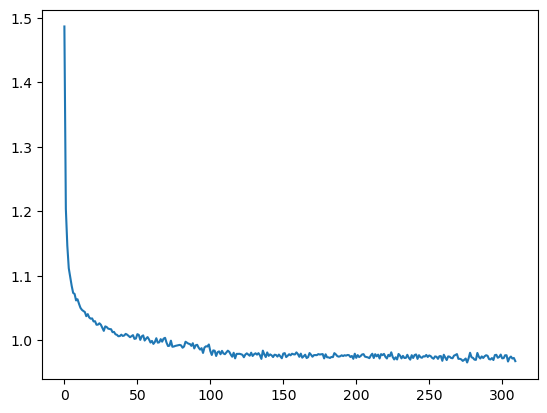

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [13]:
# Load the model from checkpoint
checkpoint = torch.load('models/WaveNet_checkpoint_300000.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model on train and dev sets
model.to('cpu')
model.eval()
total_params = sum(p.numel() for p in model.parameters())   
print(f'{total_params:,} total parameters.')
with torch.no_grad():
    logits = model(Xtr)
    loss = F.cross_entropy(logits, Ytr)
    print('train', loss.item())
    logits = model(Xdev)
    loss = F.cross_entropy(logits, Ydev)
    print('dev', loss.item())

64,243 total parameters.
train 0.9688035249710083
dev 0.9918062686920166


In [21]:
# sample from the model
checkpoint = torch.load('models/WaveNet_checkpoint_300000.pt')
block_size = 16
vocab_size = 13
n_embd = 10
n_hidden = 100  #68
#model = makemoreWaveNet(vocab_size, n_embd, n_hidden)
model = makemoreWaveNet_ver2(vocab_size, n_embd, n_hidden)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
genList = []
with torch.no_grad():
    for _ in range(10000):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            # forward pass the neural net
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            # if we sample the special '.' token, break
            if ix == 0:
                break
        
        genList.append(''.join(itos[i] for i in out).replace('.','')) # decode and collect the generated smiles

In [22]:
genList

['CC1(C)CC#C1',
 'NC1=C2ON2N1',
 'N1=NC1=C1C#C1',
 'OC12ONC1=C2',
 'NC(N)NON',
 'C=C1NNNO1',
 'N1N2C3C1=C=C23',
 'CC1=C(C)CC1',
 'C1NC2OCC12',
 'NC1(CC1)OO',
 'NN(CO)N=N',
 'CC(=N)OC#N',
 'NC1C2=C1CC2',
 'CN=C1OC=C1',
 'CN1ONN=N1',
 'NCC(N)=C',
 'O1C23C4C11C2C341',
 'OC1CN1N=N',
 'OON(O)C#C',
 'CCC=CON',
 'OCC(=C)C#N',
 'N=CN=C1CN1',
 'C=C1NN1C#C',
 'CC12C=C1C2=N',
 'CC1=CNNN1',
 'NN1ON2N=C12',
 'NC(N)C(N)=O',
 'NC(CO)OO',
 'NN1NC(O)O1',
 'OC1(O)C=C1',
 'C1N=CN2N=C12',
 'C1CC11C=N1',
 'CCOOON',
 'OCNC#CO',
 'CC=NC1=C=C1',
 'C1=C=NC=C=C1',
 'NCC1C2CC12',
 'NN=NOC#C',
 'ON1CC1C=O',
 'CC(C=C)=CO',
 'N1N2N1N1ON21',
 'NNNCON',
 'CN(C)N1N=N1',
 'CC#CN(N)O',
 'C1NC2=NN=C12',
 'OC(O)=C=O',
 'N=C1NC1=C=N',
 'CC1=NN(O)O1',
 'ON=NC1=NO1',
 'OC1=NCN=C1',
 'CC1(C)OON1',
 'CC1=CN1N=N',
 'OC=NOC=N',
 'NNC1CO1',
 'NCC(N)=O',
 'CC(O)ON=N',
 'CCC=C(C)N',
 'OC1=C2CC1C2',
 'OC(=N)N1C=N1',
 'CNCCNC',
 'C1N2N(C)C12',
 'CC#CN(C)C',
 'ONC=C1NO1',
 'NC=CNC=O',
 'NC1C=C1C',
 'C1N2OC1=C=N2',
 'N1NC2=C1N=N2',
 'C

In [23]:
# Check for validity
from rdkit import Chem
# Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

validCount = 0
uniqueList = []
for s in genList:
    if Chem.MolFromSmiles(s):
        validCount += 1
        canonicalSmiles = Chem.MolToSmiles(Chem.MolFromSmiles(s))
        if canonicalSmiles not in uniqueList:
            uniqueList.append(canonicalSmiles) 
print(f"Valid SMILES: {validCount}/{len(genList)}")
print(f"Unique SMILES: {len(uniqueList)}/{validCount}")

Valid SMILES: 9860/10000
Unique SMILES: 8497/9860


In [17]:
import rdkit
print(rdkit.__version__)

2024.03.3


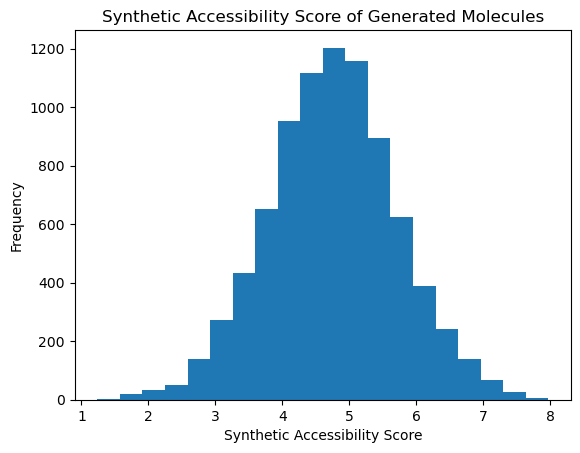

In [18]:
# Compute synthetic accessibility score 
import sys, os
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from SA_Score.sascorer import calculateScore
sasList = [calculateScore(Chem.MolFromSmiles(s)) for s in uniqueList]
plt.hist(sasList, bins=20)
plt.xlabel('Synthetic Accessibility Score')
plt.ylabel('Frequency')
plt.title('Synthetic Accessibility Score of Generated Molecules')
plt.show()

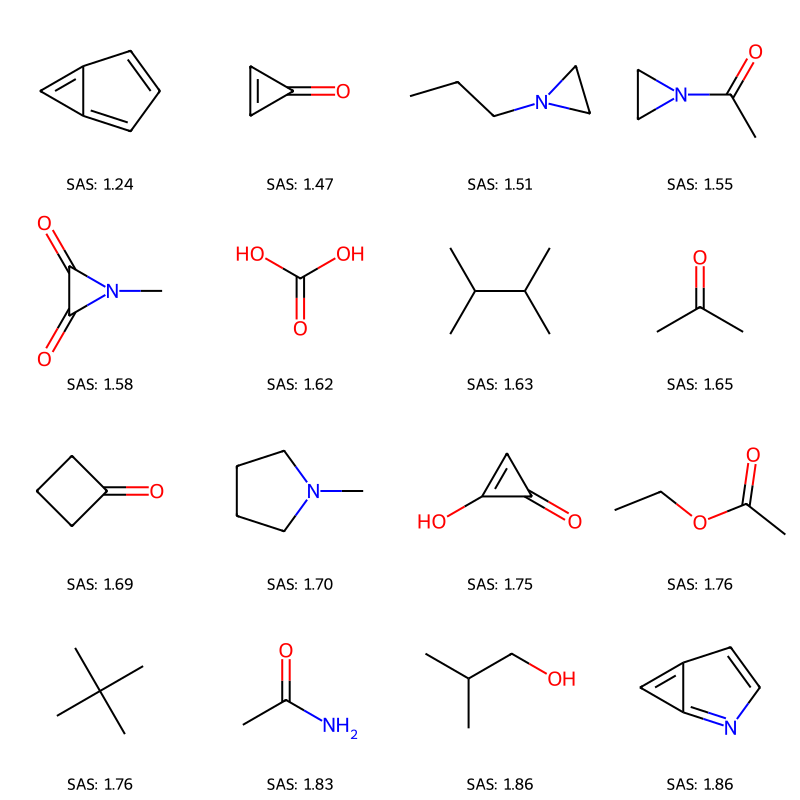

In [19]:
# Sort the generated molecules by synthetic accessibility score
from rdkit.Chem import Draw
sortedList = [s for _,s in sorted(zip(sasList,uniqueList), reverse=False)]
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[:16]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[:16]])

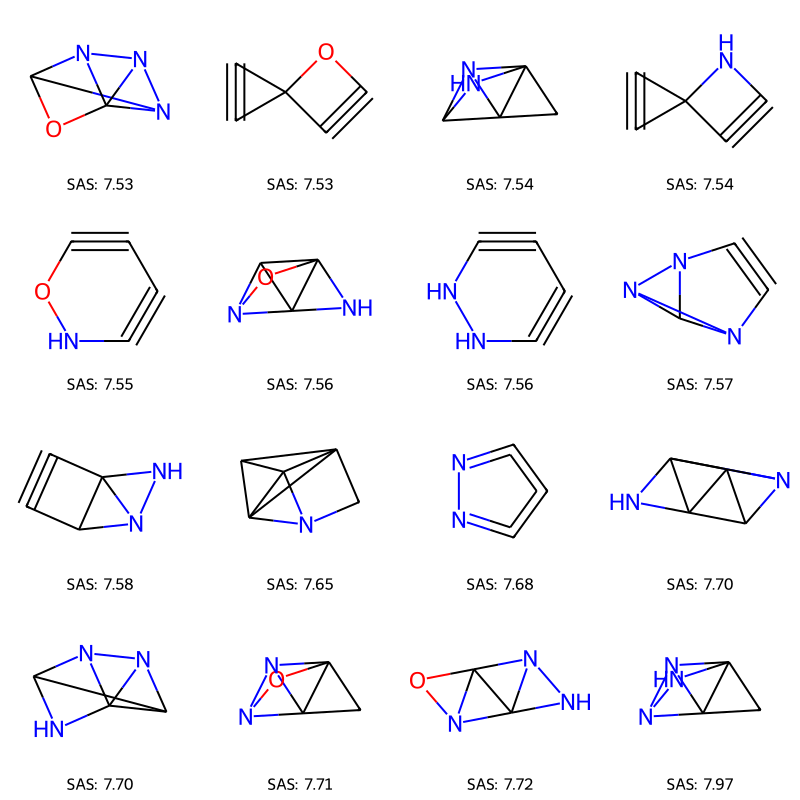

In [20]:
# Draw the molecules with the highest synthetic accessibility score
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[-16:]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[-16:]])